In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  glob
from scipy.spatial import ConvexHull
from Constants import Const
import joblib
from pointcloud_utils import *
from scipy.spatial.distance import cdist, pdist, squareform
import matplotlib as mpl

import plotly.graph_objects as go
from pointcloud_utils import *
%matplotlib notebook

from ReaderWriter import DicomReaderWriter, folder_worker
from multiprocessing import cpu_count
import typing
import os
from queue import *
from tqdm import tqdm
from threading import Thread
import pickle
import simplejson
import open3d as o3d

In [2]:
#skip to loading pickle if not editing stuff

In [3]:
class BetterDicomReader(DicomReaderWriter):
    
    def __init__(self,ddir,**kwargs):
        kwargs['verbose'] = True
        kwargs['get_dose_output'] = True
        super(BetterDicomReader,self).__init__(**kwargs)
        self.walk_through_folders(ddir)
    
    def get_contour_mask_index(self,name):
        names = self.Contour_Names
        if name in names:
            return names.index(name) + 1
        return -1

    def set_by_uid(self,uid):
#         format_string = lambda x: str(x)
#         if isinstance(uid,int):
        format_string = lambda x: int(x)
    
        for key, pdict in self.series_instances_dictionary.items():
            if format_string(pdict.get('PatientID')) == format_string(uid):
                self.index = key
                return True
        print('failed to find patient id', uid)
        return False
    
    def get_all_uids(self):
        uids = [(k, pdict.get('PatientID',-1)) for k,pdict in self.series_instances_dictionary.items()]
        uids = sorted(uids, key = lambda x: x[0])
        return [u[1] for u in uids]
    
    def get_patient(self,uid=None,index=None):
        if uid is None and index is None:
            print('need index or uid')
            return False
        if uid is not None:
            if index is not None:
                print('using uid instead of index')
            format_string = lambda x: int(x)
            for key, pdict in self.series_instances_dictionary.items():
                if format_string(pdict.get('PatientID')) == format_string(uid):
                    return pdict
        else:
            pdict = self.series_instances_dictionary.get(index)
            return pdict
        
    def get_current_patient(self):
        return self.series_instances_dictionary[self.index]
    
    def walk_through_folders(self, input_path: typing.Union[str, bytes, os.PathLike],
                             thread_count=int(cpu_count() * 0.9 - 1)):
        """
        Iteratively work down paths to find DICOM files, if they are present, add to the series instance UID dictionary
        :param input_path: path to walk
        """
        paths_with_dicom = []
        for root, dirs, files in os.walk(input_path):
            dicom_files = [i for i in files if i.endswith('.dcm')]
            if dicom_files:
                paths_with_dicom.append(root)
                # dicom_adder.add_dicom_to_dictionary_from_path(dicom_path=root, images_dictionary=self.images_dictionary,
                #                                               rt_dictionary=self.rt_dictionary)
        if paths_with_dicom:
            q = Queue(maxsize=thread_count)
            pbar = tqdm(total=len(paths_with_dicom), desc='Loading through DICOM files')
            A = (q, pbar)
            threads = []
            for worker in range(thread_count):
                t = Thread(target=folder_worker, args=(A,))
                t.start()
                threads.append(t)
            for index, path in enumerate(paths_with_dicom):
                item = [path, self.images_dictionary, self.rt_dictionary, self.rd_dictionary, self.rp_dictionary,
                        self.verbose]
                q.put(item)
            for i in range(thread_count):
                q.put(None)
            for t in threads:
                t.join()
            self.__compile__()
        if self.verbose or len(self.series_instances_dictionary) > 1:
            for key in self.series_instances_dictionary:
                print('Index {}, description {} at {}'.format(key,
                                                              self.series_instances_dictionary[key]['Description'],
                                                              self.series_instances_dictionary[key]['Image_Path']))
            print('{} unique series IDs were found. Default is index 0, to change use '
                  'set_index(index)'.format(len(self.series_instances_dictionary)))
        self.__check_if_all_contours_present__()
        return None
    
    def __repr__(self):
        return str({k: v for k,v in self.series_instances_dictionary[self.index].items() if 'files' not in str(k).lower()})


In [4]:
def get_associations(dr):
    #temp code for simplifying organ names so at gtvs are like they are in the processed data
    associations = {}
    all_rois = dr.return_rois()
    for roi in all_rois:
        if 'ctv ' in roi.lower() or roi.lower() == 'ctv':
            associations[roi] = 'CTV'
        if 'gtv ' in roi or roi.lower() == 'gtv':
            if 'node' in roi:
                associations[roi] = 'GTVn'
            else:
                associations[roi] = 'GTVp'
        if 'oar' in roi:
            associations[roi] = roi.replace('oar','').strip()
    return associations

def get_all_patients(dicom_dir, rois = None, associations = None):
    #process dicom files for all patients
    #doesn't extract info yet
    if rois is None:
        rois = [c.lower() for c in Const.organ_list] + ['GTVp','GTVn']
    dr = BetterDicomReader(dicom_dir)
    if associations is None:
        associations = get_associations(dr)
    
    dr.set_contour_names_and_associations(Contour_Names=rois,associations=associations)
    
    all_uids = dr.get_all_uids()
    plist = []
    roi_map = {i+1: roi for i,roi in enumerate(rois)}
    for uid in all_uids:
        #dicom reader reads everthing but only processes the current UID
        dr.set_by_uid(uid)
        dr.get_images_and_mask()
        patient = dr.get_current_patient()
        #image slices as a stack
        patient['ArrayDicom'] = dr.ArrayDicom[:]
        #same shape as arraydicom, replaces values with the index corresponding to each roi
        patient['mask'] = dr.mask[:].astype(np.int32)
        #save the index -> roi dictionary for later
        patient['roi_mask_map'] = roi_map
        plist.append(patient)
    return plist, roi_map

#temp subset of organs to test with since it takes a while to run it all
rois = ['GTVp','GTVn',
        'brainstem',
        'esophagus',
        'hard_palate',
        'ipc','larynx','lower_lip',
        'lt_ant_digastric_m','rt_ant_digastric_m',
        'lt_mastoid','rt_mastoid',
        'lt_masseter_m','rt_masseter_m',
        'mpc','ipc','spc',
        'soft_palate','upper_lip',
        'rt_sternocleidomastoid_m','lt_sternocleidomastoid_m',
       ]

#Get a list of dictionaries with processed patient info from the dicom
plist, roi_map = get_all_patients(Const.dicom_test_dir,rois=rois)
plist

Loading through DICOM files:   0%|                       | 0/21 [00:00<?, ?it/s]

Loading from ../data//SMART/1/CT- 1
Loading from ../data//SMART/1/RTIMAGE_unknown_/series
Loading from ../data//SMART/1/RTSTRUCT_unknown_/series
Loading from ../data//SMART/3/RTDOSE_unknown_/seriesLoading from ../data//SMART/3/RTPLAN_unknown_/series

Loading from ../data//SMART/2/RTPLAN_unknown_/series
Loading from ../data//SMART/2/RTSTRUCT_unknown_/series
Loading from ../data//SMART/1/RTDOSE_unknown_/series
Loading from ../data//SMART/3/RTSTRUCT_unknown_/series
Loading from ../data//SMART/2/CT-2
Loading from ../data//SMART/3/CT-3
Loading from ../data//SMART/2/RTDOSE_unknown_/series
Loading from ../data//SMART/1/RTPLAN_unknown_/series


Loading through DICOM files:   5%|▋              | 1/21 [00:00<00:10,  1.92it/s]

Had an error loading ../data//SMART/2/RTPLAN_unknown_/series/ima_empty_uid_2.16.840.1.113669.2.931128.192763.20161117115505.661473.dcm
Loading from ../data//SMART/4/CT-4
Had an error loading ../data//SMART/3/RTPLAN_unknown_/series/ima_empty_uid_2.16.840.1.113669.2.931128.192763.20161117120903.481418.dcm
Loading from ../data//SMART/4/RTDOSE_unknown_/series
Had an error loading ../data//SMART/1/RTPLAN_unknown_/series/ima_empty_uid_2.16.840.1.113669.2.931128.192763.20161117114809.595057.dcm
Loading from ../data//SMART/4/RTPLAN_unknown_/series


Loading through DICOM files:  19%|██▊            | 4/21 [00:00<00:02,  5.93it/s]

Had an error loading ../data//SMART/1/RTDOSE_unknown_/series/ima_30_uid_2.16.840.1.113669.2.931128.192763.20161117114810.147583.dcm
Loading from ../data//SMART/5/CT-5
Loading from ../data//SMART/4/RTSTRUCT_unknown_/series
Had an error loading ../data//SMART/2/RTDOSE_unknown_/series/ima_1_uid_2.16.840.1.113669.2.931128.192763.20161117115506.239940.dcm
Had an error loading ../data//SMART/3/RTDOSE_unknown_/series/ima_1_uid_2.16.840.1.113669.2.931128.192763.20161117120904.15446.dcm
Had an error loading ../data//SMART/4/RTDOSE_unknown_/series/ima_1_uid_2.16.840.1.113669.2.931128.192763.20161117121333.804247.dcmLoading from ../data//SMART/5/RTDOSE_unknown_/series

Loading from ../data//SMART/5/RTPLAN_unknown_/series
Loading from ../data//SMART/5/RTSTRUCT_unknown_/series


Loading through DICOM files:  43%|██████▍        | 9/21 [00:01<00:01,  7.67it/s]

Had an error loading ../data//SMART/4/RTPLAN_unknown_/series/ima_empty_uid_2.16.840.1.113669.2.931128.192763.20161117121333.115836.dcm


Loading through DICOM files:  57%|████████      | 12/21 [00:01<00:01,  6.61it/s]

Had an error loading ../data//SMART/5/RTPLAN_unknown_/series/ima_empty_uid_2.16.840.1.113669.2.931128.192763.20161117121646.169888.dcm


Loading through DICOM files:  67%|█████████▎    | 14/21 [00:02<00:01,  5.27it/s]

Had an error loading ../data//SMART/5/RTDOSE_unknown_/series/ima_1_uid_2.16.840.1.113669.2.931128.192763.20161117121646.676089.dcm


Loading through DICOM files: 100%|██████████████| 21/21 [00:19<00:00,  1.10it/s]


Compiling dictionaries together...
Index 0, description  at ../data//SMART/3/CT-3
Index 1, description  at ../data//SMART/4/CT-4
Index 2, description  at ../data//SMART/2/CT-2
Index 3, description  at ../data//SMART/5/CT-5
Index 4, description  at ../data//SMART/1/CT- 1
Index 5, description None at ../data//SMART/1/RTIMAGE_unknown_/series
6 unique series IDs were found. Default is index 0, to change use set_index(index)
The following ROIs were found
marked iso
sclv d=3cm
imrt ref pnt
ctv1
ctv 1 sub
ptv 1
ctv2
ctv 2 sub
ptv 2
ctv3
ctv 3 sub
ptv 3
r parotid
l parotid
gtv
spinal cord
spinal cord+0.5cm
brainstem
brainstem+0.5cm
external
contracted external
ring
rt parotid sub
lt parotid sub
total ptv
nt avoidance
pen on couch
get 6996
get 5700
get 6300
cooldown
push
c1_vertebra
c2_vertebra
c3_vertebra
c4_vertebra
c5_vertebra
c6_vertebra
c7_vertebra
cricoid_cartilage
cricopharyngeal_muscle
esophagus
extended_oral_cavity
genioglossus_m
glottic_area
hard_palate
hyoid_bone
ipc
larynx
lower_lip

Loading images for  at 
 ../data//SMART/4/CT-4

Loading images for  at 
 ../data//SMART/2/CT-2

Loading images for  at 
 ../data//SMART/5/CT-5

Loading images for  at 
 ../data//SMART/1/CT- 1



[{'PatientID': '001',
  'SeriesInstanceUID': '1.2.840.113704.1.111.2624.1214247243.15',
  'Files': ('../data//SMART/3/CT-3/ima_174_uid_1.2.840.113704.1.111.2096.1214247328.697.dcm',
   '../data//SMART/3/CT-3/ima_173_uid_1.2.840.113704.1.111.2096.1214247328.696.dcm',
   '../data//SMART/3/CT-3/ima_172_uid_1.2.840.113704.1.111.2096.1214247328.695.dcm',
   '../data//SMART/3/CT-3/ima_171_uid_1.2.840.113704.1.111.2096.1214247328.694.dcm',
   '../data//SMART/3/CT-3/ima_170_uid_1.2.840.113704.1.111.2096.1214247328.693.dcm',
   '../data//SMART/3/CT-3/ima_169_uid_1.2.840.113704.1.111.2096.1214247327.692.dcm',
   '../data//SMART/3/CT-3/ima_168_uid_1.2.840.113704.1.111.2096.1214247327.691.dcm',
   '../data//SMART/3/CT-3/ima_167_uid_1.2.840.113704.1.111.2096.1214247326.690.dcm',
   '../data//SMART/3/CT-3/ima_166_uid_1.2.840.113704.1.111.2096.1214247326.689.dcm',
   '../data//SMART/3/CT-3/ima_165_uid_1.2.840.113704.1.111.2096.1214247326.688.dcm',
   '../data//SMART/3/CT-3/ima_164_uid_1.2.840.113704.

In [5]:


def get_roi_pointclouds(pdict, roi_map, scale = True, concavify=True,**kwargs):
    #get locations of contours.  I may need to tweak this part if I want to get actual dose values?
    clouds = {}
    #get the corresponding image value of each point. will add stuff for dose later idk
    pixel_values = {}
    mask = pdict['mask']
    image_stack = pdict['ArrayDicom']
    #get array locations
    all_points = []
    for index, roi in roi_map.items():
        #should be x, y, z if I tranpose it (default it's slicexheightxwidth)
        contour = np.argwhere(mask.T == index)
        (cx, cy, cz) = np.where(mask.T == index)
        point_values = image_stack.T[cx,cy,cz].ravel()
        #skip bad values with < 4 points because the algorithms break
        if contour.shape[0] > 3:
            #this should get the points on the surface of the object (concave hull) if parameters are good
            if concavify:
                #test a few different alpha shapes to see which has the most points
                ascales = [.1,.2,.3,.4,.5,1,1.5] #test a few different alphas and return one with the most points to be safe
                si_list = concave_hull_3d(contour,return_vertices = True,alpha_scales=ascales,**kwargs)
                surface_indices = si_list[ascales.index(1)]
                #basically pick the first one that removes over half the points
                for si in si_list:
                    if len(si) < len(point_values)/2 and len(si) < 2000:
                        surface_indices = si
                        break
                print(roi, len(surface_indices), len(point_values))
                contour = contour[surface_indices]
                point_values=point_values[surface_indices]
            all_points.append(contour)
        clouds[roi] = contour
        pixel_values[roi] = point_values
    #correct for centroid of all points and scale to distance values
    if scale:
        #I'm not actually sure this is valid test later somehow
        #but recenters the points and then uses thickness to scale x,y, and z
        #may have issues if missing some organs when comparing between patients?
        all_points = np.vstack(all_points)
        center = cloud_centroid(all_points)
        zscale = pdict['Slice_Thickness']
        xscale = pdict['Pixel_Spacing_X']
        yscale = pdict['Pixel_Spacing_Y']
        if xscale != yscale:
            print('different height/widht scales',xscale,yscale)
        #todo: make sure this actually works if I ge a comparison baseline
        for k,v in clouds.items():
            if v.shape[0] < 1:
                continue
            v = v - center
            v[0,:] = v[0,:]*xscale
            v[1,:] = v[1,:]*yscale
            v[2,:] = v[2,:]*zscale
            v = filter_pcloud_outliers(v)
            clouds[k] = v.astype(np.float32)
    
    return clouds, pixel_values


def pc_dist_worker(args):
    #wrapper to help parallelize pointcloud distance calclations
    if args[0] == args[1]:
        return 0
    clouds = args[2]
    return pointcloud_distance(clouds[args[0]],clouds[args[1]])

def get_interorgan_distances(roi_clouds, roi_map=None, concavify=False,parallel=True,**kwargs):
    #calc interorgan distances on a dict of {roi: pointcloud, roi2: pointcloud2} as an array
    #also returns the order of rois in the dict [r1, r2, r3,...] =>[ [d(r1,r1),d(r1,r2),d(r1,r3)], [d(r2,r1),d(r2,r2),d(r2,r3)],...]
    if roi_map is not None:
        rois = [roi_map[k] for k in sorted(roi_map)]
    else:
        rois = list(roi_clouds.keys())
    dists = []
    #get convex hull for interorgan_distance if I remove that from the default processing
    if concavify:
        roi_clouds = pcloud_to_concave_hull(roi_clouds,alpha_scale=1.5,**kwargs)
    for roi in rois:
        if parallel:
            dlist = joblib.Parallel(n_jobs=-2)(joblib.delayed(pc_dist_worker)((roi,r2,roi_clouds)) for r2 in rois)
        else:
            dlist = [pc_dist_worker((roi,r2,roi_clouds)) for r2 in rois]     
        dists.append(dlist)
        print(roi,'done')

    return np.array(dists), rois

def calc_spatial_info(pdict):
    #adds each roi's convex hull as a list of points and calculates inter-organ min distances
    temp = {k: v for k, v in pdict.items()}
    roi_clouds, roi_values = get_roi_pointclouds(pdict, roi_map=roi_map,scale=True,concavify=False)
#     roi_clouds, roi_values = get_roi_pointclouds(pdict, roi_map=roi_map,scale=True)
    io_dists, rois = get_interorgan_distances(roi_clouds, roi_map)
    temp['contours'] = roi_clouds
    temp['contour_values'] = roi_values
    temp['distances'] = io_dists
    #also compress files
    temp['mask'] = temp['mask'].astype(np.int32)
    return temp

def process_patient_list(plist, roi_map = None, n_jobs=1):
    #takes the patient dicts and adds calculates spatial stats
    #currently gives and out-of-memory error if n_jobs > 1
    new_plist = joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(calc_spatial_info)(pdict) for pdict in plist)
    return new_plist

plist = process_patient_list(plist,roi_map)
plist[0]

GTVp done
GTVn done
brainstem done
esophagus done
hard_palate done
ipc done
larynx done
lower_lip done
lt_ant_digastric_m done
rt_ant_digastric_m done
lt_mastoid done
rt_mastoid done
lt_masseter_m done
rt_masseter_m done
mpc done
ipc done
spc done
soft_palate done
upper_lip done
rt_sternocleidomastoid_m done
lt_sternocleidomastoid_m done
GTVp done
GTVn done
brainstem done
esophagus done
hard_palate done
ipc done
larynx done
lower_lip done
lt_ant_digastric_m done
rt_ant_digastric_m done
lt_mastoid done
rt_mastoid done
lt_masseter_m done
rt_masseter_m done
mpc done
ipc done
spc done
soft_palate done
upper_lip done
rt_sternocleidomastoid_m done
lt_sternocleidomastoid_m done
GTVp done
GTVn done
brainstem done
esophagus done
hard_palate done
ipc done
larynx done
lower_lip done
lt_ant_digastric_m done
rt_ant_digastric_m done
lt_mastoid done
rt_mastoid done
lt_masseter_m done
rt_masseter_m done
mpc done
ipc done
spc done
soft_palate done
upper_lip done
rt_sternocleidomastoid_m done
lt_sternoc

{'PatientID': '001',
 'SeriesInstanceUID': '1.2.840.113704.1.111.2624.1214247243.15',
 'Files': ('../data//SMART/3/CT-3/ima_174_uid_1.2.840.113704.1.111.2096.1214247328.697.dcm',
  '../data//SMART/3/CT-3/ima_173_uid_1.2.840.113704.1.111.2096.1214247328.696.dcm',
  '../data//SMART/3/CT-3/ima_172_uid_1.2.840.113704.1.111.2096.1214247328.695.dcm',
  '../data//SMART/3/CT-3/ima_171_uid_1.2.840.113704.1.111.2096.1214247328.694.dcm',
  '../data//SMART/3/CT-3/ima_170_uid_1.2.840.113704.1.111.2096.1214247328.693.dcm',
  '../data//SMART/3/CT-3/ima_169_uid_1.2.840.113704.1.111.2096.1214247327.692.dcm',
  '../data//SMART/3/CT-3/ima_168_uid_1.2.840.113704.1.111.2096.1214247327.691.dcm',
  '../data//SMART/3/CT-3/ima_167_uid_1.2.840.113704.1.111.2096.1214247326.690.dcm',
  '../data//SMART/3/CT-3/ima_166_uid_1.2.840.113704.1.111.2096.1214247326.689.dcm',
  '../data//SMART/3/CT-3/ima_165_uid_1.2.840.113704.1.111.2096.1214247326.688.dcm',
  '../data//SMART/3/CT-3/ima_164_uid_1.2.840.113704.1.111.2096.12

In [6]:
with open(Const.data_dir+'test_dicom_processed_full.p','wb') as f:
    pickle.dump(plist , f)


In [7]:
with open(Const.data_dir+'test_dicom_processed_full.p','rb') as f:
    plist = pickle.load( f ) 
plist

[{'PatientID': '001',
  'SeriesInstanceUID': '1.2.840.113704.1.111.2624.1214247243.15',
  'Files': ('../data//SMART/3/CT-3/ima_174_uid_1.2.840.113704.1.111.2096.1214247328.697.dcm',
   '../data//SMART/3/CT-3/ima_173_uid_1.2.840.113704.1.111.2096.1214247328.696.dcm',
   '../data//SMART/3/CT-3/ima_172_uid_1.2.840.113704.1.111.2096.1214247328.695.dcm',
   '../data//SMART/3/CT-3/ima_171_uid_1.2.840.113704.1.111.2096.1214247328.694.dcm',
   '../data//SMART/3/CT-3/ima_170_uid_1.2.840.113704.1.111.2096.1214247328.693.dcm',
   '../data//SMART/3/CT-3/ima_169_uid_1.2.840.113704.1.111.2096.1214247327.692.dcm',
   '../data//SMART/3/CT-3/ima_168_uid_1.2.840.113704.1.111.2096.1214247327.691.dcm',
   '../data//SMART/3/CT-3/ima_167_uid_1.2.840.113704.1.111.2096.1214247326.690.dcm',
   '../data//SMART/3/CT-3/ima_166_uid_1.2.840.113704.1.111.2096.1214247326.689.dcm',
   '../data//SMART/3/CT-3/ima_165_uid_1.2.840.113704.1.111.2096.1214247326.688.dcm',
   '../data//SMART/3/CT-3/ima_164_uid_1.2.840.113704.

In [26]:
#all code below is testing ways of viewing the files

In [4]:
len(plist)

2

In [27]:
def display_slices(pdict, indexes = None, skip=1):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """
    image = pdict['ArrayDicom'][51:77]
    mask = pdict['mask'][51:77]
    print(np.unique(mask))
    if indexes is None:
        indexes = [c for c in np.unique(mask) if c != 0]
    slice_locations = np.unique(np.where( np.isin(mask,indexes) )[0]) # get indexes for where there is a contour present 
    if slice_locations.shape[0] < 1:
        return False
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    counter = 1
    n_images = slice_end - slice_start + 1
    n_rows = int((n_images+1)/2)
    size = 3
    fig,axes = plt.subplots(n_rows,2,squeeze=True,figsize=(2*size,n_rows*size))
    fig.set_tight_layout(True)
    row = 0
    col = 0
    for img_arr, contour_arr in zip(image[slice_start:slice_end+1], mask[slice_start:slice_end+1]): # plot the slices with contours overlayed ontop
        if counter % skip == 0: # if current slice is divisible by desired skip amount 
            masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
            ax = axes[row,col]
            ax.imshow(img_arr, cmap='gray', interpolation='none')
            ax.margins(x=0,y=0)
            ax.axis('off')
            ax.imshow(masked_contour_arr, cmap='OrRd', interpolation='none', alpha=0.5, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice
#             plt.show()
            col += 1
            if col > 1:
                col = 0
                row += 1
        counter += 1

# display_slices(plist[-1])

In [26]:
def voxel_downsample(pcloud,size=2):
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(pcloud)
    pc = pc.voxel_down_sample(size)
    output = np.asarray(pc.points)
#     print(pcloud.shape,output.shape)
    return output
voxel_downsample(plist[0]['contours']['GTVp'])

array([[  0.5,  -7. ,  13. ],
       [  0.5,  -9. ,  13. ],
       [  0.5, -11. ,  13. ],
       ...,
       [-25.5,  18.5,  27. ],
       [-17. ,   8.5,  17. ],
       [-17. ,  11. ,  29. ]])

In [57]:
def voxel_downsample(pcloud,size=2):
    pc = o3d.geometry.PointCloud()
    pc.points = o3d.utility.Vector3dVector(pcloud)
    pc = pc.voxel_down_sample(voxel_size=size)
    output = np.asarray(pc.points)
    return output
voxel_downsample(plist[0]['contours']['brainstem'])

array([[16.5       , 50.5       , 44.5       ],
       [16.5       , 49.        , 44.5       ],
       [17.        , 47.        , 44.5       ],
       ...,
       [ 9.16666667, 61.16666667, 49.        ],
       [ 3.        , 36.5       , 38.        ],
       [ 3.        , 37.        , 49.        ]])

In [62]:
def plotly_contours(pdict,concavify=False,downsample=2):
    contours = pdict['contours']
    data = []
    for organ, points in contours.items():
        if points.shape[0] < 5:
            continue
        if concavify:
            points = concave_hull_3d(points)
        if downsample > 1:
            preshape = points.shape[0]
            points = voxel_downsample(points,downsample)
            print(preshape,points.shape[0])
        color = 'gray'
        if 'gtvp' in organ.lower():
            color = 'red'
        elif 'gtvn' in organ.lower():
            color = 'yellow'
        subplot = go.Scatter3d(
            x=points[:,0], y=points[:,1], z=points[:,2], 
            text=organ,
            mode='markers',
            marker=dict(size=1,color=color)
        )
        data.append(subplot)
    fig = go.Figure(
        data = data,
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    return fig

plotly_contours(plist[-1],downsample=4).show()

10489 781
1025 129
2590 235
1516 154
1116 88
1903 238
922 116
998 89
982 91
304 34
200 21
1830 248
1847 240
334 40
1082 132
318 81
1548 141
1641 474
1684 457


<IPython.core.display.Javascript object>


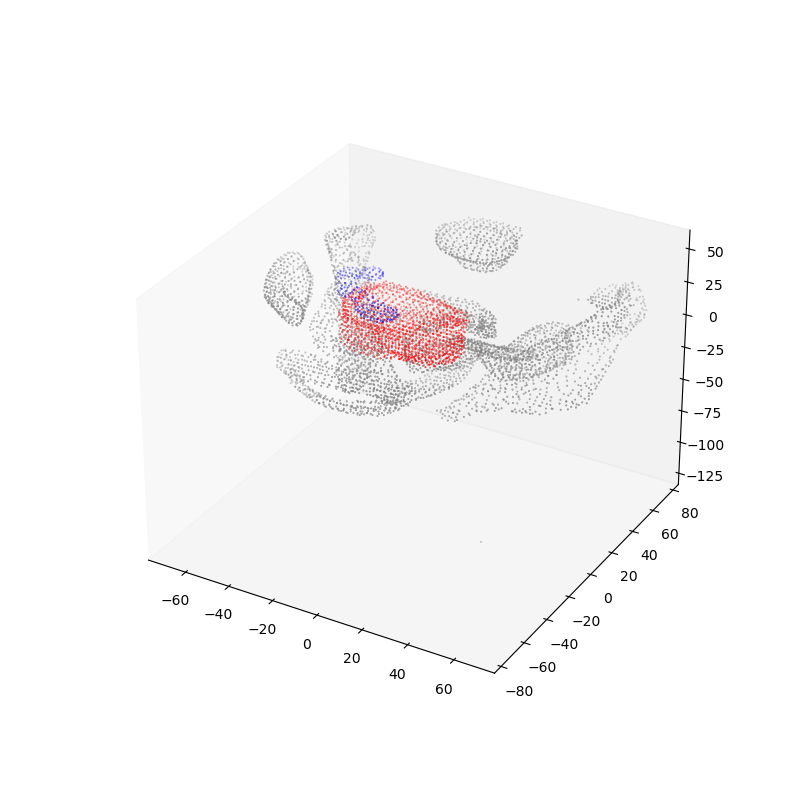

<Axes3DSubplot:>

In [66]:
#static version
def plot_pclouds(pdict,figsize=(8,8),convexify=False,downsample=4,**kwargs):
    fig = plt.figure(figsize=figsize,facecolor='w')
    ax = fig.add_subplot(projection='3d')
    ax.set_facecolor('w')
    ax.grid(False)
    colors = mpl.colormaps['tab20']
    contours = pdict['contours']
    for i,(roi,pointcloud) in enumerate(contours.items()):
        if pointcloud.shape[0] < 4:
            continue
        size = .2
        if convexify:
            preshape = pointcloud.shape[0]
            pointcloud =concave_hull_3d(npointcloud,**kwargs)
        
        if downsample > 1:
            pointcloud = voxel_downsample(pointcloud,downsample)
        color = 'red' if 'gtvp' in roi.lower() else ('blue' if 'gtvn' in roi.lower() else 'grey')
        ax.scatter(pointcloud[:,0],pointcloud[:,1],pointcloud[:,2],s=size,color=color)
    return ax

plot_pclouds(plist[-1],alpha=None,downsample=3)

In [ ]:
def alpha_shape_3d(pos, alpha=None, ratio = None):
    #basically this tries to get all the points on the outsie surface of the pointcloud
    #edited from other code I cant find anymore using an alpha-shape algorith
    #defaults to mean radius as alpha value because this works best based on trial and error
    """
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """

    tetra = Delaunay(pos)
    # Find radius of the circumsphere.
    # By definition, radius of the sphere fitting inside the tetrahedral needs 
    # to be smaller than alpha value
    # http://mathworld.wolfram.com/Circumsphere.html
    tetrapos = np.take(pos,tetra.vertices,axis=0)
    normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
    ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
    a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
    Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
    Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
    Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
    c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
    r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a) + .001)
    r = np.nan_to_num(r)
    # Find tetrahedrals
    if alpha is None:
        if ratio is not None:
            alpha = np.quantile(r,[ratio]) 
        else:
            alpha = np.mean(r)
    tetras = tetra.vertices[r<alpha,:]
    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)
    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:
        TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    return Vertices,Edges,Triangles

import alphashape

def concave_hull_2d(points,alpha=None):
    if alpha is None:
        alpha = 0.95 * alphashape.optimizealpha(points)
    hull = alphashape.alphashape(points, alpha)
    return hull

def get_levelsets(pc,get_boundary=True):
    levels = sorted(np.unique(pc[:,2]))
    levelsets = []
    boundaries = []
    alpha = None
    for level in levels:
        largs = np.argwhere(pc[:,2] == level)
        lset = pc[largs.ravel()]
        levelsets.append(lset)
        if get_boundary:
            points = lset[:,0:2]
            if points.shape[0] > 5:
                #compute alpha for the first level and then stick with it
                if alpha is None:
                    alpha = 0.95 * alphashape.optimizealpha(points)
                try:
                    hull = concave_hull_2d(points,alpha=alpha)
                    xx,yy = hull.exterior.coords.xy
                except:
                    hull = concave_hull_2d(points,alpha=0)
                    xx,yy= hull.exterior.coords.xy
                lset_boundary = np.array([(x,y,level) for x,y in zip(xx,yy)])
            else:
                lset_boundary = lset
            boundaries.append(lset_boundary)
    
    return levelsets,boundaries

def interpolate_between_slices(pc1,pc2,n=1,d=1):
    #interpolate between leves in a pointcloud
    dists = cdist(pc1,pc2)
    new_slice = []
    for i,subdists in enumerate(dists):
        j = np.argmin(subdists)
        p1 = pc1[i]
        p2 = pc2[j]
        p3 = ((p1*n) + (p2*d))/(n+d)
        new_slice.append(p3)
    return np.stack(new_slice)
    
def process_pointcloud(boundaries=None,n_slices=1):
#     levelsets,boundaries = get_levelsets(pc)
    new_boundaries = []
    for i in range(len(boundaries)-1):
        slice1 = boundaries[i]
        slice2 = boundaries[i+1]
        new_boundaries.append(slice1)
        for i in range(n_slices):
            newslice = interpolate_between_slices(slice1,slice2,(i+1),(n_slices-i))
            new_boundaries.append(newslice)
        new_boundaries.append(slice2)
    return np.vstack(new_boundaries)

def interpolate_clouds(contours):
    new_contours = {}
    for roi,pcloud in contours.items():
        if pcloud.shape[0] < 2:
            print(roi,'skipped')
            continue
#         _,boundaries = get_levelsets(pcloud)

        newpcloud = concave_hull_3d(pcloud)
        boundaries,_ = get_levelsets(newpcloud,False)
        
        new_pcloud = process_pointcloud(boundaries)
        new_contours[roi] = new_pcloud
        print(pcloud.shape,new_pcloud.shape)
#         if len(new_contours) > 3:
#             break
    return new_contours

test = interpolate_clouds(plist[-1]['contours'])
plotly_contours({'contours': test},False)

In [ ]:
def downsample_patient_clouds(pdict,downsample_size=4):
    

In [8]:
import simplejson

def prep_patient_for_export(pdict):
    to_keep = [
        'id','Spacing',
        'Volumes',
        'ArrayDicom',
#         'mask',
        'contours','contour_values',
        'distances','roi_mask_map'
    ]
    pdict['Spacing'] = (pdict['Pixel_Spacing_X'],pdict['Pixel_Spacing_Y'],pdict['Slice_Thickness'])
    pdict['id'] = int(pdict['PatientID'])
    pdict = {k: pdict.get(k) for k in to_keep}
    sub_contours = {}
#     for roi,pcloud in pdict['contours'].items():
#         small_pcloud = voxel_downsample(pcloud,4)
#         sub_contours[roi] = small_pcloud
#     pdict['reduced_contours']= sub_contours
    return pdict

def np_converter(obj):
    #converts stuff to vanilla python  for json since it gives an error with np.int64 and arrays
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, float):
        return round(float(obj),4)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.bool_):
        return bool(obj)
    elif isinstance(obj, datetime.datetime) or isinstance(obj, datetime.time):
        return obj.__str__()
    print('np_converter cant encode obj of type', obj,type(obj))
    return obj
    
def np_dict_to_json(d,destination_file, nan_to_null = False):   
    try:
        with open(destination_file, 'w') as f:
            #nan_to_null makes it save it as null in the json instead of NaN
            #more useful when it's sent to a json but will be read back in python as None
            simplejson.dump(d,f,default = np_converter, ignore_nan = nan_to_null)
        return True
    except Exception as e:
        print(e)
        return False
    
def pdict_to_json(pdict,destination_file=Const.data_dir+'plist.json',**kwargs):
    pdict = prep_patient_for_export(pdict)

    pjson = np_dict_to_json(pdict,destination_file,**kwargs)
    return pjson


prep_patient_for_export(plist[-1])

{'id': 5,
 'Spacing': (0.9375, 0.9375, 3.0),
 'Volumes': array([86.53126863,  5.81267612, 29.51884323,  8.69137688,  3.98198162,
         3.0224147 , 18.70934397,  4.91059477,  4.95923641,  5.07641855,
         1.07674906,  0.55937887, 26.83470903, 25.78228079,  1.68919154,
         0.        , 13.65724625, 12.99395114,  7.00881829, 47.24872143,
        49.31156921]),
 'ArrayDicom': array([[[-1000.,  -850.,  -823., ...,  -816.,  -861.,  -824.],
         [ -840.,  -837.,  -859., ...,  -859.,  -822.,  -819.],
         [ -833.,  -852.,  -834., ...,  -822.,  -838.,  -819.],
         ...,
         [ -893.,  -883.,  -882., ...,  -826.,  -838.,  -833.],
         [ -882.,  -876.,  -901., ...,  -834.,  -822.,  -831.],
         [ -873.,  -888.,  -905., ...,  -818.,  -829.,  -836.]],
 
        [[-1000.,  -807.,  -844., ...,  -849.,  -863.,  -872.],
         [ -814.,  -832.,  -825., ...,  -875.,  -856.,  -856.],
         [ -844.,  -811.,  -799., ...,  -853.,  -855.,  -862.],
         ...,
        

In [39]:
pdict_to_json(plist[-1])

/home/evl/andrew/anaconda3/envs/Qubbed/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



True

In [9]:
def pickle_plist(plist, file='processed_dicoms_full.p'):
    ids = set([])
    pl = []
    for p in plist:
        if p['PatientID'] in ids:
            print('redundant_id',p['PatientID'])
            continue
        ids.add(p['PatientID'])
        pp = prep_patient_for_export(p)
        pl.append(pp)
    with open(Const.data_dir+file,'wb') as f:
        pickle.dump(pl , f)
    with open(Const.data_dir+file,'rb') as f:
        pl = pickle.load( f ) 
    return pl

pickle_plist(plist)

redundant_id 005


[{'id': 1,
  'Spacing': (0.9765625, 0.9765625, 3.0),
  'Volumes': array([26.63135529,  0.        , 33.3070755 ,  8.60452652,  2.96831131,
          4.45365906, 22.89772034,  5.17606735,  7.52210617,  7.9369545 ,
          2.08854675,  1.50918961, 28.38373184, 26.48115158,  2.2816658 ,
          0.        , 16.41273499,  9.59634781,  8.70943069, 89.06841278,
         90.30342102]),
  'ArrayDicom': array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],
  
         [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024., ..., -1024., -1024., -1024.]

In [2]:
plist

NameError: name 'plist' is not defined

In [ ]:
test = plist[-1]['contours']['brainstem']

In [ ]:
test